## Introduction

The goal of this classification task is to predict the survival state of patients with liver cirrhosis during the course of the study. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import shap

from lightgbm import LGBMClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

from pathlib import Path
from typing import Optional, List, Dict

plt.style.use('ggplot')
plt.rcParams.update({'figure.dpi':150})

In [2]:
train = pd.read_csv(data_path / 'train.csv', index_col=['id'])
test = pd.read_csv(data_path / 'test.csv', index_col=['id'])

train.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
id,,,,,,,,,,,,,,,,,,,
0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C


In [3]:
print(f'Number of observations in training data: {train.shape[0]}')
print(f'Number of columns in training data: {train.shape[1]}')

Number of observations in training data: 7905
Number of columns in training data: 19


## EDA

We first check if there is any feature for which its mode has more than 90% of the observations. It is unlikely that any model can reliably use such features. So, we will drop them

In [4]:
from numbers import Number
def get_mode_fraction(x:pd.Series) -> float:
    cts = x.value_counts(sort=True, ascending=False)
    return cts.iloc[0]/x.shape[0]

def filter_greater_than(series:pd.Series,threshold:Number) -> pd.Series:
    '''
    Returns series elements greater than threshold. This funtion can be
    used with the .pipe methods
    '''
    return series[series>threshold]

high_mode_per = (
    train.drop('Status', axis=1)
    .apply(get_mode_fraction)
    .pipe(filter_greater_than, threshold = 0.9)
)
high_mode_per

Sex        0.928020
Ascites    0.951929
Edema      0.905882
dtype: float64

In [5]:
# drop these columns
train = train.drop(high_mode_per.index.tolist(), axis=1)

We then check if any of the columns have any missing entries. There appear to be none.

In [6]:
# check for missing values
(
    train
    .isna()
    .sum()
    .pipe(filter_greater_than, 0)
)

Series([], dtype: int64)

We then inspect the training data. Apart from the target `Status`, there are 3 categorical-valued columns. The rest are all numerical. 

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7905 entries, 0 to 7904
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         7905 non-null   int64  
 1   Drug           7905 non-null   object 
 2   Age            7905 non-null   int64  
 3   Hepatomegaly   7905 non-null   object 
 4   Spiders        7905 non-null   object 
 5   Bilirubin      7905 non-null   float64
 6   Cholesterol    7905 non-null   float64
 7   Albumin        7905 non-null   float64
 8   Copper         7905 non-null   float64
 9   Alk_Phos       7905 non-null   float64
 10  SGOT           7905 non-null   float64
 11  Tryglicerides  7905 non-null   float64
 12  Platelets      7905 non-null   float64
 13  Prothrombin    7905 non-null   float64
 14  Stage          7905 non-null   float64
 15  Status         7905 non-null   object 
dtypes: float64(10), int64(2), object(4)
memory usage: 1.0+ MB


### Target

The categorical target to predict is `Status`. There are three classes:
- `C`: the patient was alive at `N_Days`
- `CL`: the patient was alive at `N_Days` due to a liver transplant
- `D`: the patient was deceased at `N_Days`,

Here `N_Days` is the number of days between registration and the earlier of death, transplantation or the end of the study. 

There is quite a bit of class imbalance. In particular, there are very few observations for class `CL`. This makes sense as liver transplants are not too common. 

In [8]:
# compute percentage of training observations per class
train['Status'].value_counts() / train.shape[0] * 100

Status
C     62.808349
D     33.712840
CL     3.478811
Name: count, dtype: float64

### Categorical features

There are 3 categorical features (after the initial preprocessing step), and all 3 are binary valued.

In [9]:
categorical_cols = []
for col in train.drop('Status', axis=1).columns:
    if train[col].dtype == 'object':
        categorical_cols.append(col)
        print(f"{col} has  {train[col].nunique()} unique values")

Drug has  2 unique values
Hepatomegaly has  2 unique values
Spiders has  2 unique values


Both categories of `Drug` and `Hepatomegaly` occur roughly in the same number of observations, while presence of `Spiders` (='Y') is far less common. 

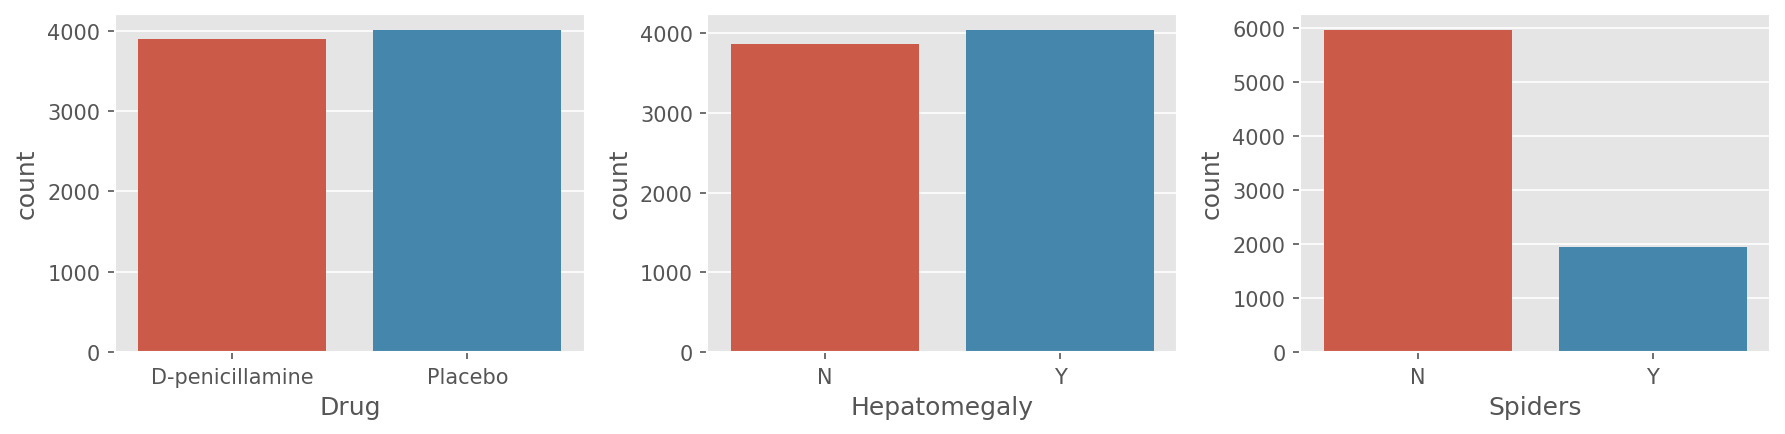

In [10]:
fig,axs = plt.subplots(1, len(categorical_cols), figsize=(4 * len(categorical_cols), 3))
for i in range(len(categorical_cols)):
    _ = sns.countplot(
        data=train, x=categorical_cols[i], ax=axs[i])
fig.tight_layout()

In the cell below, we plot the percentage of the class for each level of the 3 categorical features. Some observations:

1. Administering the drug is associated with slightly worse outcomes. It remains to be seen if this association is significant or not.
2. Presence of hepatomegaly is associated with much worse than outcomes than the absence.
3. Presence of spiders is associated with much worse than outcomes than the absence.

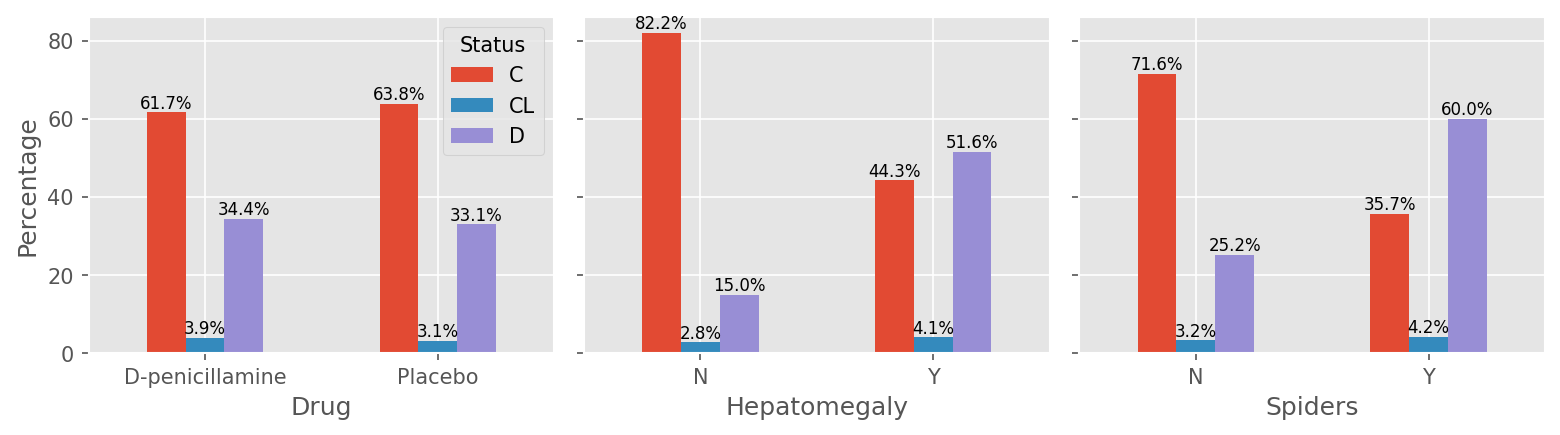

In [11]:
fig,axs = plt.subplots(1, len(categorical_cols), figsize=(3.5 * len(categorical_cols), 3), sharey=True)
for i in range(len(categorical_cols)):
    bars  = (
        train
        .groupby(categorical_cols[i])['Status']
        .value_counts(normalize=True)
        .mul(100)
        .rename('Percentage')
        .unstack()
        .fillna(0)
        .plot(kind='bar', stacked=False, rot=0, ax=axs[i])
    )
    
    for bar in bars.patches:
        yval = bar.get_height()
        axs[i].annotate(
            f'{yval:.1f}%', 
            (bar.get_x() + bar.get_width() / 2, yval),
            ha='center', va='bottom',
            fontsize=8
        )
    
    # titles
    _ = axs[i].set_ylabel('Percentage')
    if i > 0:
        _ = axs[i].get_legend().remove()
fig.tight_layout()

### Numerical features

We first plot the histograms of the numerical features to check for skewness. While this is not strictly needed for the tree-based models, the analysis might still be useful.

From the plot, 'Bilirubin', 'Cholesterol', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Prothrombin' appear to have a large positive skew. 

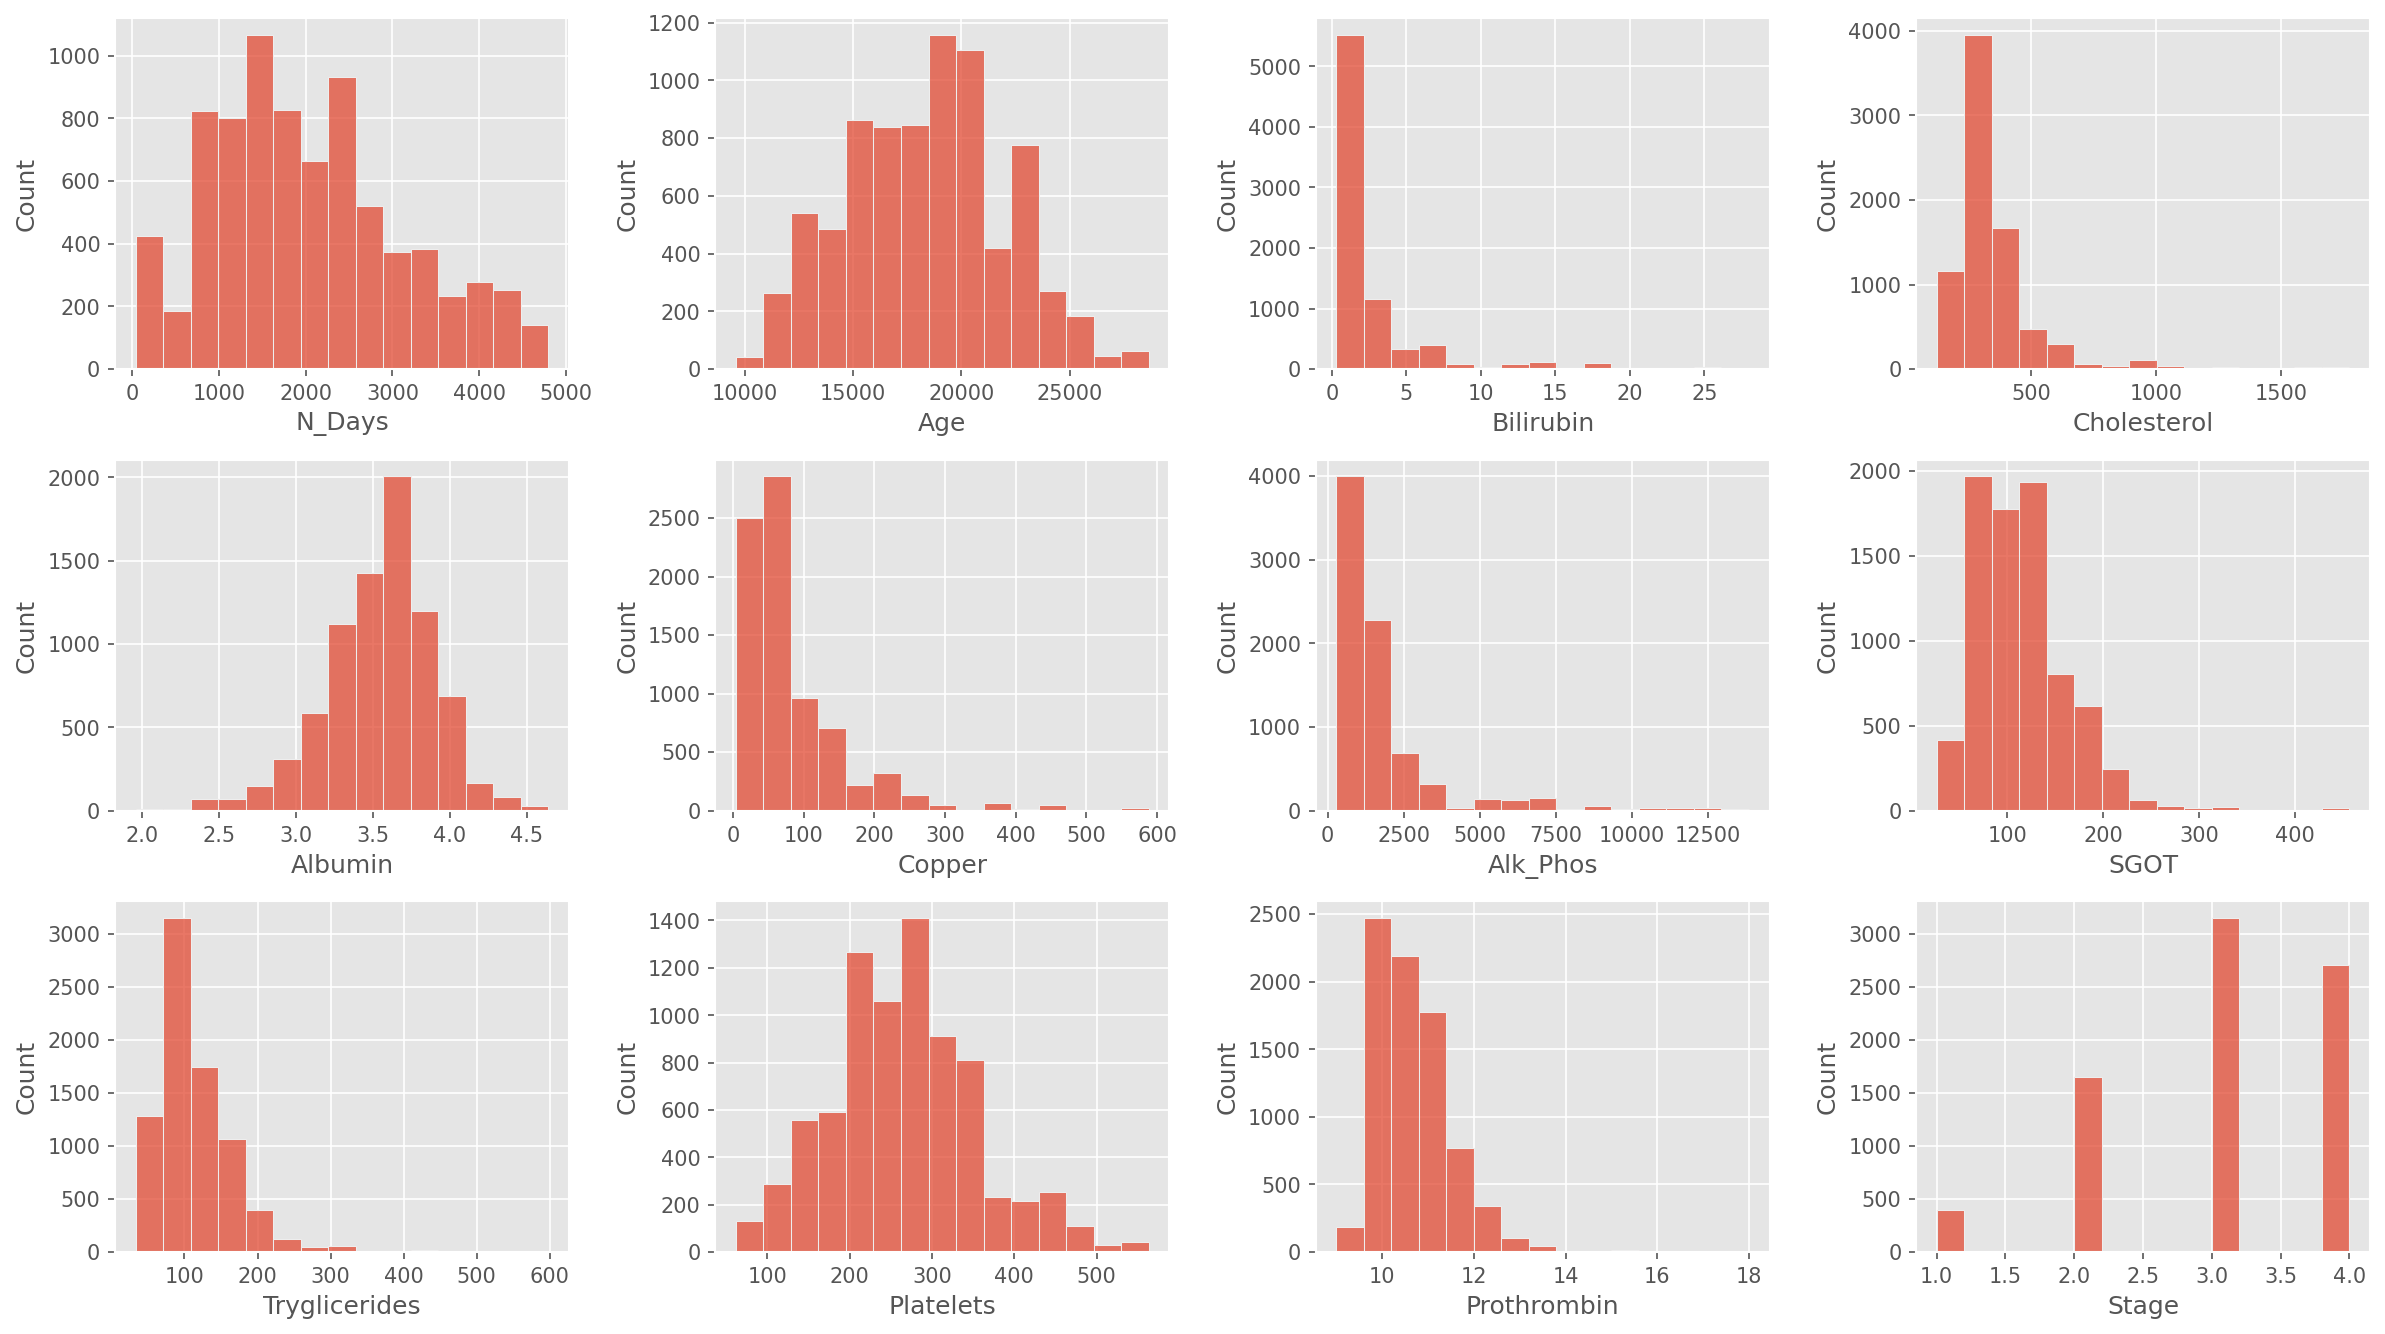

In [12]:
numerical_cols = train.select_dtypes(include='number').columns.tolist()

n_rows = 3
n_cols = 4
fig, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
for i in range(n_rows):
    for j in range(n_cols):
        _ = sns.histplot(data=train, x=numerical_cols[n_cols * i + j], ax=axs[i, j], bins=15)

fig.tight_layout()

For these columns, we plot the boxplots with a log1p transform to check if there are any outliers. It turns out there are some outliers in the transformed variables.

TODO: Handle outliers.

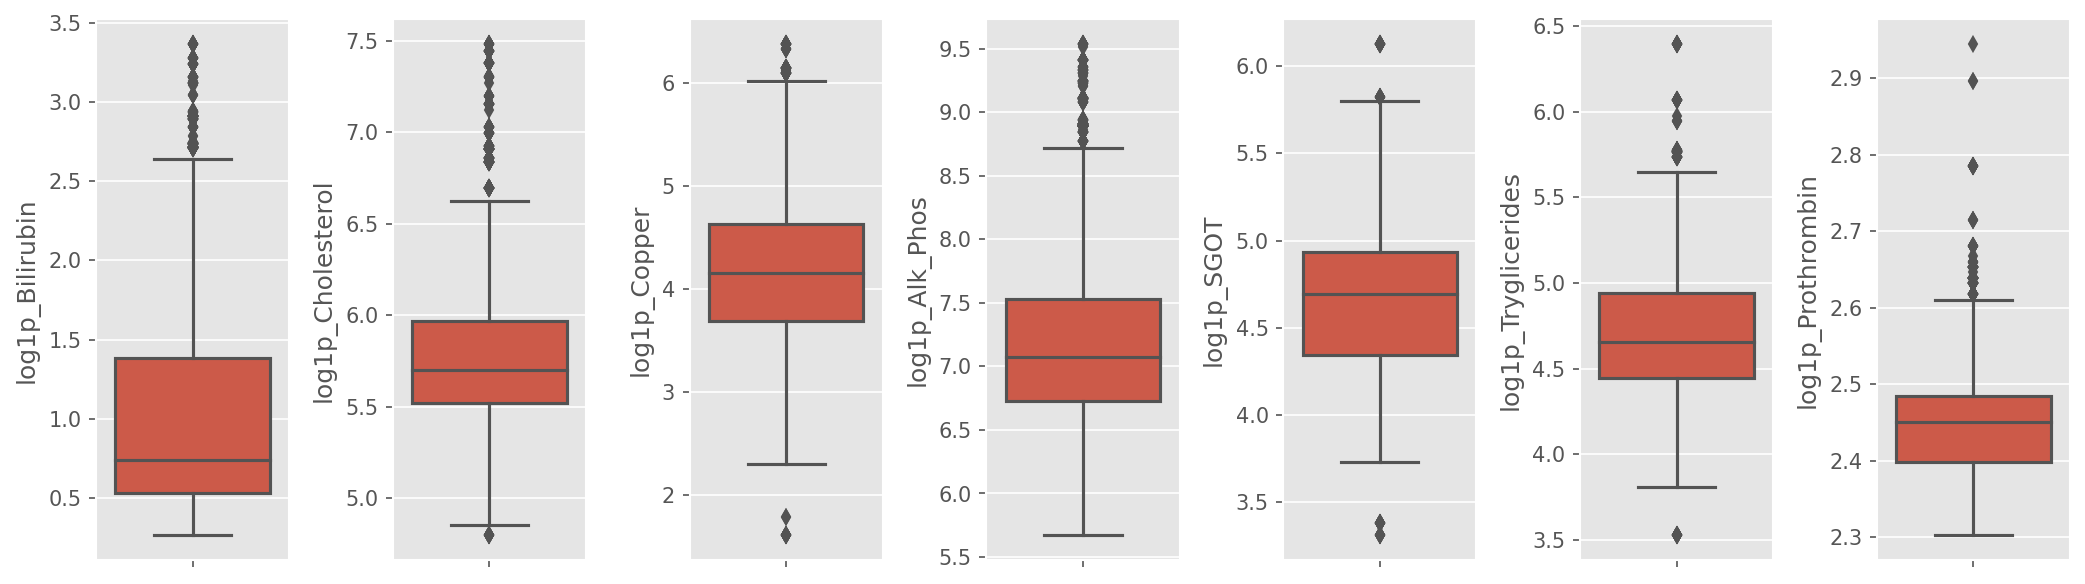

In [13]:
pos_skewed_cols = train[numerical_cols].skew().pipe(filter_greater_than, 1).index.tolist()

fig, axs = plt.subplots(1, len(pos_skewed_cols), figsize=(2 * len(pos_skewed_cols), 4))
for i, col in enumerate(pos_skewed_cols):
    _ = sns.boxplot(y = np.log1p(train[col]), ax=axs[i])
    _ = axs[i].set_ylabel(f'log1p_{col}')
fig.tight_layout()

Finally, we  plot the boxplots of ALL numerical features grouped by the different classes. There doesn't seem to be any significant pattern that sticks out. The models might benefit from some careful feature engineering.

TODO: Feature engineering.

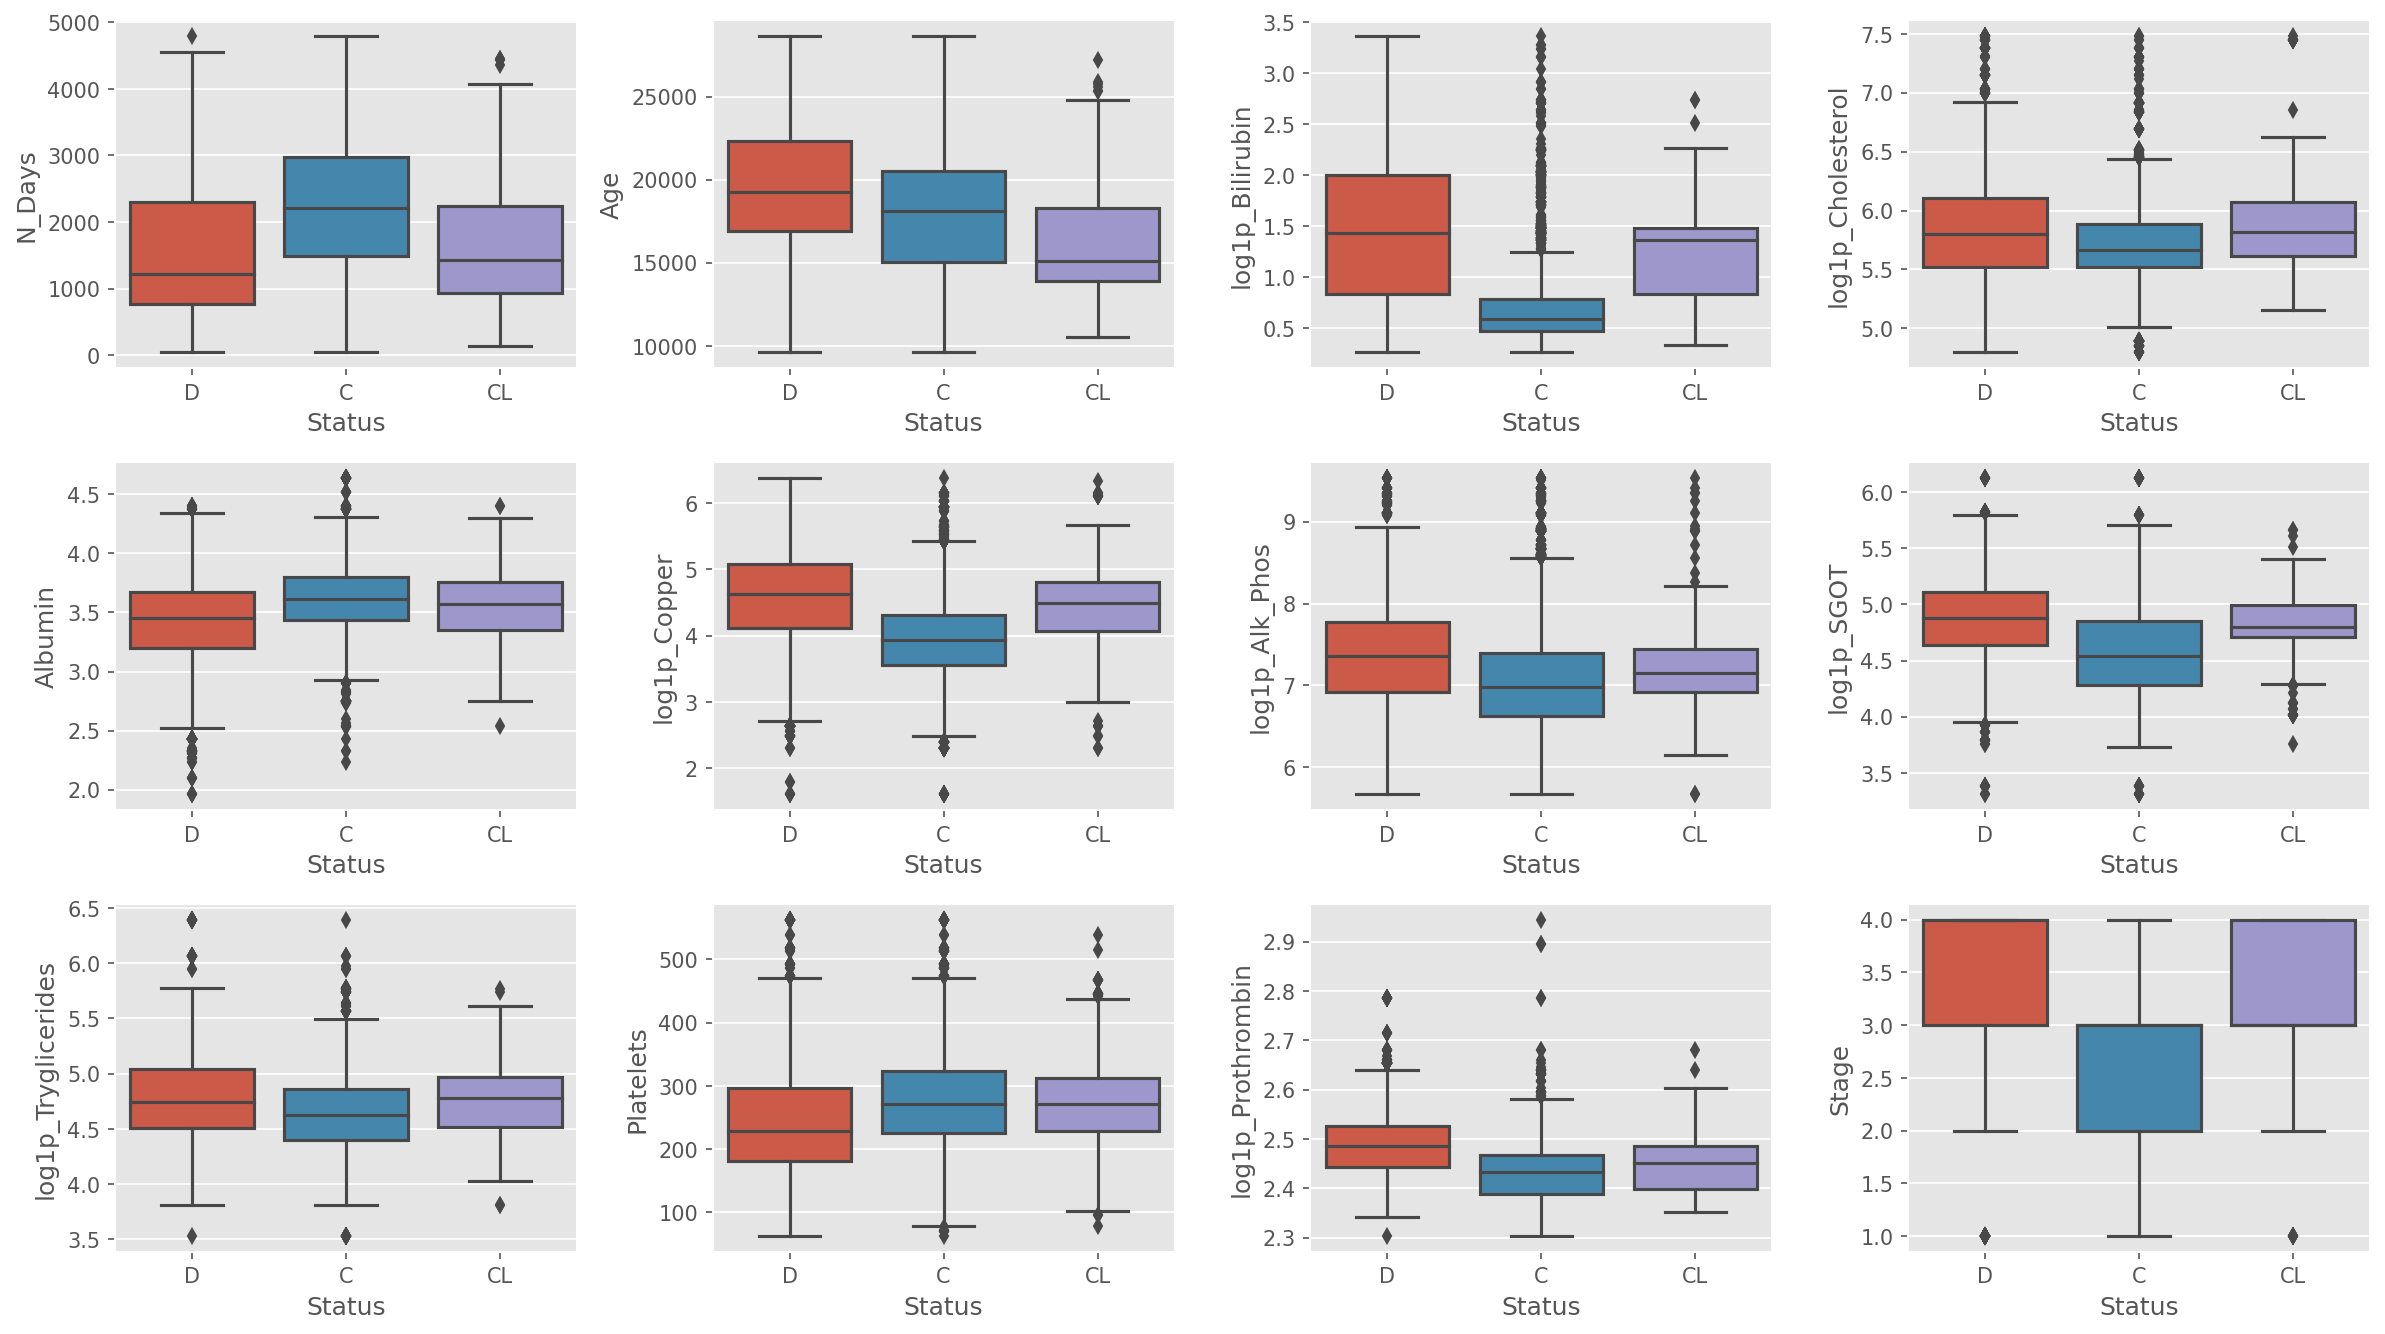

In [14]:
n_rows = 3
n_cols = 4
fig, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
for i in range(n_rows):
    for j in range(n_cols):
        col = numerical_cols[n_cols * i + j]
        if col in pos_skewed_cols:
            _ = sns.boxplot(y=np.log1p(train[col]), x=train['Status'], ax=axs[i, j])
            _ = axs[i, j].set_ylabel(f'log1p_{col}')
        else:
            _ = sns.boxplot(data=train, y=col, x='Status', ax=axs[i, j])

fig.tight_layout()

### Preparing the data

In [15]:
## convert binary columns to 0 or 1
pos_labels = {
    'Drug': 'D-penicillamine',
    'Hepatomegaly': 'Y',
    'Spiders': 'Y'
}

X = train.drop('Status', axis=1)
for col, pos_label in pos_labels.items():
    X[col] = 1 * (X[col] == pos_label)


# encode labels
le = LabelEncoder()
y = le.fit_transform(train['Status'])

## Lightgbm model - training interface

In [16]:
def fit_model(
    X:pd.DataFrame,
    y:np.ndarray,
    config:Optional[Dict]=None,
    n_jobs:int=1
) -> LGBMClassifier:
    '''
    Train a lightgbm classifier on the data
    '''
    
    model = LGBMClassifier(
        n_jobs = n_jobs,
        importance_type='gain',
        subsample_freq=1
    )
    
    if config:
        # if config is supplied, set the model hyperparameters
        model.set_params(**config)
        
    return model.fit(X,y)

## Tuning hyperparameters via Optuna 

In [17]:
import joblib
# uncomment the following line to log only ERROR messages
# optuna.logging.set_verbosity(optuna.logging.ERROR)

def fit_and_test_fold(config:Dict,train_index,test_index) -> float:
    X_train = X.iloc[train_index,:]; X_test = X.iloc[test_index,:]
    y_train = y[train_index]; y_test = y[test_index]
    
    # fit model on training data
    model = fit_model(X_train,y_train,config,n_jobs=4)
    
    # generate predictions on test data
    test_pred_prob = model.predict_proba(X_test)
    
    return log_loss(y_test,test_pred_prob)

# loss function
def objective(trial):
    config = {
        'n_estimators':trial.suggest_int('n_estimators',50, 1500,log=True),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 0.75,log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256, log=True),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.1, 1),
        'colsample_bynode': trial.suggest_float("colsample_bynode", 0.1, 1),
        'subsample': trial.suggest_float("subsample", 0.1, 1),
        'min_child_samples':trial.suggest_int('min_child_samples',20, 200),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 100,log=True), # l1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda',1e-8, 100, log=True), # l2 regularization
        'min_split_gain': trial.suggest_float('min_split_gain',1e-8,100, log=True), # gamma in xgboost,
    }
    
    
    # 4-fold cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    
    cv_losses = [None]*5
    for i,(train_index, test_index) in enumerate(cv.split(X, y)):
        cv_losses[i] = fit_and_test_fold(config, train_index, test_index)
    
    return np.mean(cv_losses)

# the first `n_startup_trials` trials are drawn through random sampling
sampler = optuna.samplers.TPESampler(
    n_startup_trials=10,# recommended minimum: max(5,1+no_of_hyperparameters)
    seed=123
)

study = optuna.create_study(
    directions=['minimize'],sampler=sampler,study_name='lgbm'
)


study.optimize(objective, n_trials=100, timeout=1500) 
joblib.dump(study, "lgbm_survival.pkl") # save study for further runs


[I 2023-12-08 02:42:13,930] A new study created in memory with name: lgbm
[I 2023-12-08 02:42:18,420] Trial 0 finished with value: 0.7219274636862434 and parameters: {'n_estimators': 533, 'learning_rate': 0.00024828288762242625, 'num_leaves': 5, 'colsample_bytree': 0.5961832921746021, 'colsample_bynode': 0.7475220728070068, 'subsample': 0.4807958141120149, 'min_child_samples': 197, 'reg_alpha': 0.07051757771805378, 'reg_lambda': 0.0006446426195647978, 'min_split_gain': 8.340175355380263e-05}. Best is trial 0 with value: 0.7219274636862434.
[I 2023-12-08 02:42:20,221] Trial 1 finished with value: 0.4574996547403469 and parameters: {'n_estimators': 160, 'learning_rate': 0.03582300284516207, 'num_leaves': 14, 'colsample_bytree': 0.15371010694861154, 'colsample_bynode': 0.4582398297973883, 'subsample': 0.7641958651588321, 'min_child_samples': 53, 'reg_alpha': 5.682213681437011e-07, 'reg_lambda': 0.0020678247942007765, 'min_split_gain': 0.0020810181641723407}. Best is trial 1 with value: 0.

['lgbm_survival.pkl']

In [19]:
results = study.trials_dataframe(attrs=('number','value', 'duration', 'params'))
results = results.rename(columns={'value':'log_loss'})
results['duration'] = results['duration']/np.timedelta64(1, 's')
results = results.sort_values(by='log_loss',ascending=True)
results.to_csv('cv_logloss_history.csv',index=False)
# print the top 10 results
results.head(10)

,number,log_loss,duration,params_colsample_bynode,params_colsample_bytree,params_learning_rate,params_min_child_samples,params_min_split_gain,params_n_estimators,params_num_leaves,params_reg_alpha,params_reg_lambda,params_subsample
90,90,0.425810,6.611059,0.743551,0.120700,0.029014,37,0.000594,430,26,0.001320,2.718714e-08,0.790824
89,89,0.426624,5.520467,0.741198,0.117045,0.038231,27,0.000619,338,25,0.000990,3.352479e-08,0.857333
86,86,0.426837,5.867023,0.696888,0.144174,0.042297,57,0.000328,401,24,0.008880,2.948654e-07,0.843965
91,91,0.427475,6.593880,0.738201,0.119725,0.025185,37,0.000650,422,26,0.001122,1.026730e-08,0.849984
74,74,0.427591,4.052805,0.690906,0.137705,0.055770,37,0.000073,368,14,0.000769,2.383257e-08,0.858710
92,92,0.427922,6.202212,0.733260,0.101564,0.027014,47,0.000885,414,24,0.001102,1.083096e-08,0.793189
93,93,0.428488,8.108106,0.740370,0.115000,0.024254,44,0.000706,433,25,0.001147,1.477104e-08,0.792770
96,96,0.428501,6.490552,0.745883,0.119297,0.025116,52,0.000719,422,25,0.001474,1.610213e-08,0.851095
73,73,0.428934,4.487483,0.716519,0.137316,0.052086,31,0.000205,406,14,0.001110,2.442790e-08,0.910975
72,72,0.429732,4.395064,0.726880,0.123715,0.053123,31,0.000167,399,15,0.000902,2.439993e-08,0.904087


## Final model

In [20]:
model = fit_model(X, y, study.best_params, n_jobs=4)
model.booster_.save_model(
    filename='lgbm_survival.txt',importance_type='gain'
)

In [21]:
%%time
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

CPU times: user 38.3 s, sys: 27.4 ms, total: 38.3 s
Wall time: 10.5 s


In the SHAP summary plot, we plot a horizontal bar plot of the absolute SHAP value for each feature averaged across the observations. Features with longer bars have a higher influence on the model's output for the specific class. Since we have 3 classes here, we will see 3 stacked bars for each feature. The features are ordered according to the cumulative length of the 3 bars.

Let's look at the top 3 features from the plot below.

1. `Bilirubin` is very important for predicting all three classes.
2. `N_Days` is fairly important for predicting all three classes.
3. `Age` is fairly important for predicting class `CL`. 

Notice that the binary features aren't very important.


**Note**: The SHAP scores were generated for a model trained after preliminary hyperparameter tuning. The observations might change in the final output run.

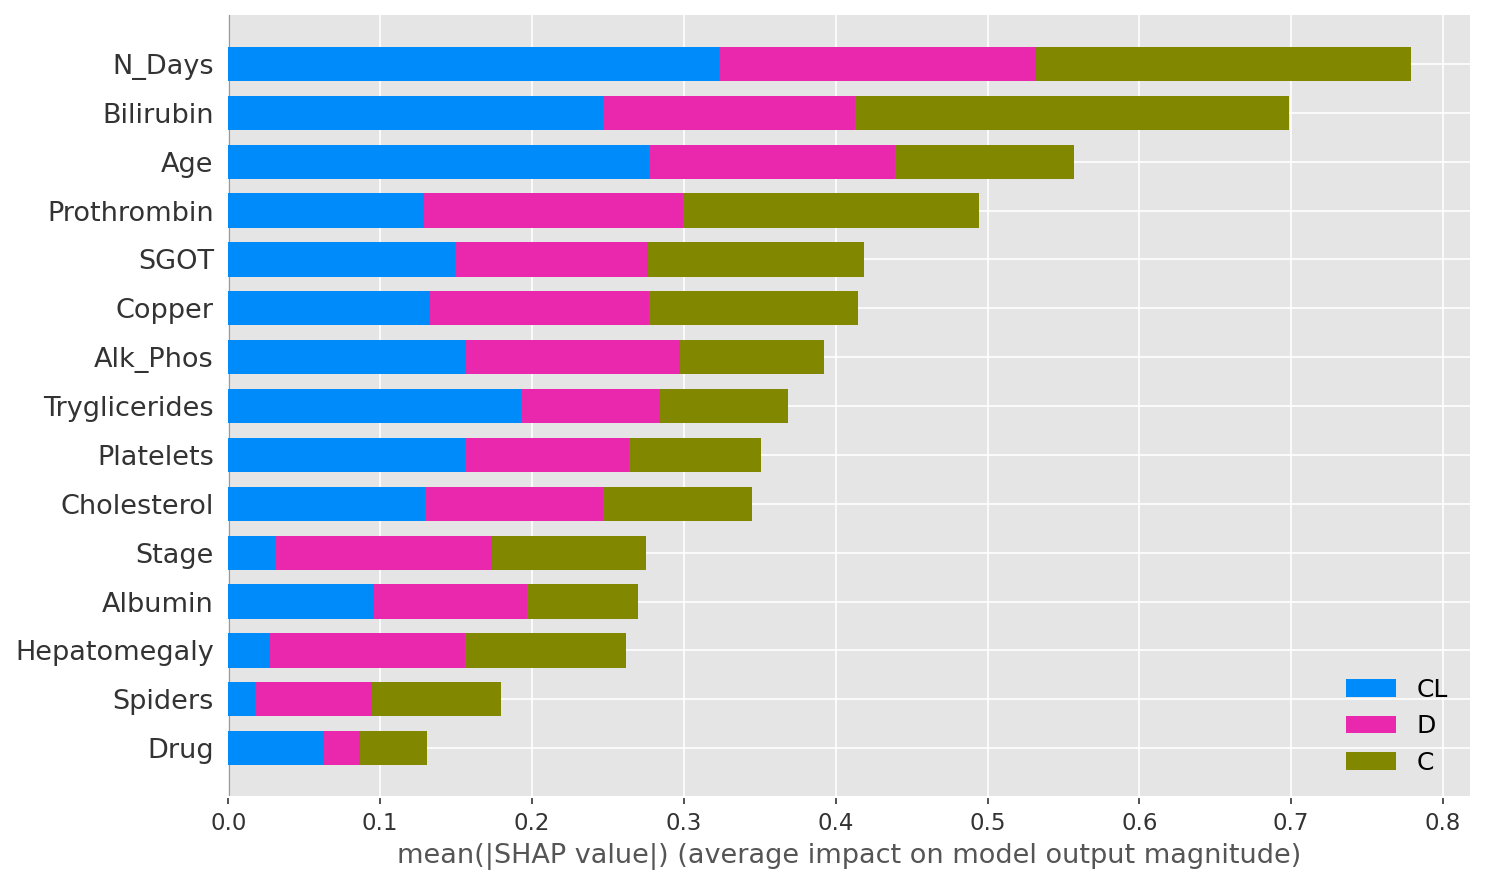

In [22]:
# Average of SHAP value magnitudes across the dataset
shap.summary_plot(
    shap_values, X, plot_type="bar",
    class_names = le.classes_,
    plot_size = (10,6)
)

In the cell below, we show the SHAP values separately by class. We only show the top 8 features.

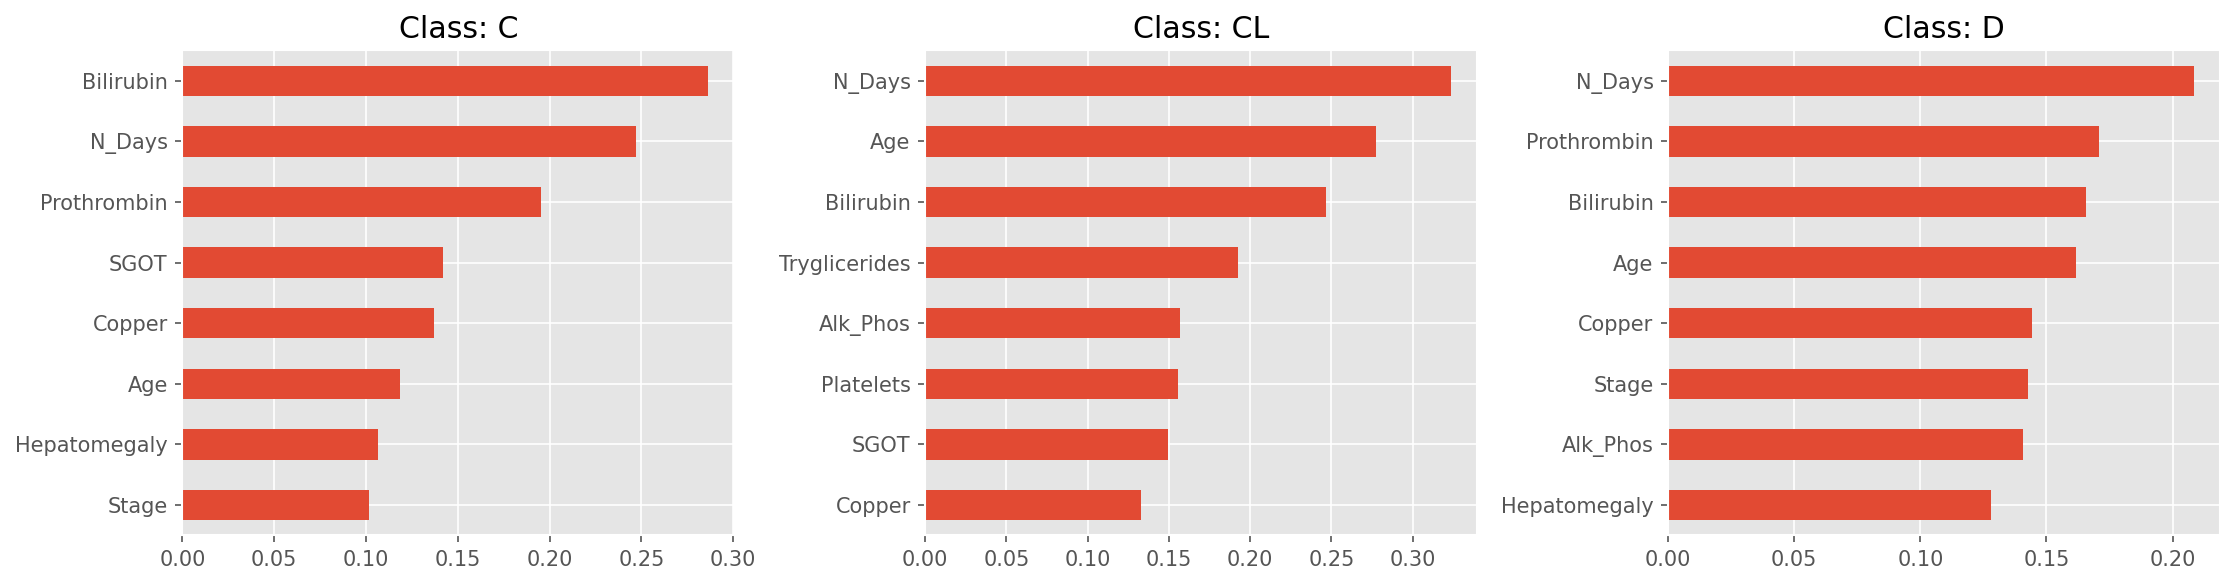

In [23]:
avg_shap_class = [
    pd.Series(
        np.abs(shap_values[i]).mean(0),
        index = X.columns.tolist()
    ).sort_values(ascending=True) for i in range(3)
]

fig, axs = plt.subplots(1, 3, figsize=(15,4), dpi=150)
for i in range(3):
    _ = avg_shap_class[i].iloc[-8:].plot(kind='barh', ax=axs[i])
    _ = axs[i].set_title(f'Class: {le.classes_[i]}')
    
fig.tight_layout()

## Test predictions

In [24]:
# prepare test data
test = test.drop(high_mode_per.index.tolist(), axis=1)

# binaryize labels
for col, pos_label in pos_labels.items():
    test[col] = 1 * (test[col] == pos_label)
    


In [25]:
submission = pd.DataFrame(
    model.predict_proba(test),
    columns = [f'Status_{label}' for label in le.classes_],
    index=test.index
).reset_index(drop=False)

submission.to_csv('submission.csv', index=False)